# Assigment 3: Uncertainty predicition (classification task)

Dropout, a technique commonly used in neural networks to prevent overfitting, can also be applied to estimate the uncertainty of a model's predictions. Normally, dropout is only active during training, where it randomly deactivates neurons to improve generalization. However, by keeping dropout active during inference—a method known as Monte Carlo (MC) Dropout—it is possible to approximate the uncertainty associated with a model's predictions.

To estimate uncertainty using MC Dropout, the model performs multiple stochastic forward passes on the same input during inference. Each pass simulates a different "thinned" version of the network, as neurons are randomly deactivated according to the dropout probabilities. For a classification task, this results in a collection of probability distributions over the output classes, one from each forward pass.

This code implements a convolutional neural network (CNN) to classify the MNIST dataset (handwritten digit images). It includes a function to generate predictions with uncertainty by sampling the model's outputs multiple times.

+ `training=True` indicates that the model should run in "training mode", enabling behaviors specific to training, such as applying dropout layers



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

def get_model():
    model = keras.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),  # Add dropout after max pooling
            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.25),  # Add dropout after max pooling
            layers.Flatten(),
            layers.Dense(128, activation="relu"),  # Add a dense layer before the output
            layers.Dropout(0.5),  # Add dropout before the final output layer
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    return model

# Create the model
model = get_model()

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7495 - loss: 0.7700 - val_accuracy: 0.9802 - val_loss: 0.0710
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9581 - loss: 0.1412 - val_accuracy: 0.9868 - val_loss: 0.0460
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9715 - loss: 0.0963 - val_accuracy: 0.9892 - val_loss: 0.0398
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9772 - loss: 0.0785 - val_accuracy: 0.9877 - val_loss: 0.0399
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9791 - loss: 0.0710 - val_accuracy: 0.9897 - val_loss: 0.0356
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9814 - loss: 0.0599 - val_accuracy: 0.9910 - val_loss: 0.0317
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9846 - loss: 0.0499 - val_accuracy: 0.9918 - val_loss: 0.0306
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9844 - loss: 0.0499 - val_accuracy: 

mean_prediction [[1.9391257e-07 1.3648454e-06 1.3636076e-05 9.7944985e-06 4.2763340e-08
  9.1219029e-08 9.5195896e-09 9.9996686e-01 5.1799401e-07 7.6835822e-06]]
std_prediction [[1.44702778e-06 8.32012847e-06 1.01906146e-04 4.11164365e-05
  3.43471243e-07 8.15519968e-07 9.40784872e-08 1.61242657e-04
  4.33415426e-06 2.71085610e-05]]


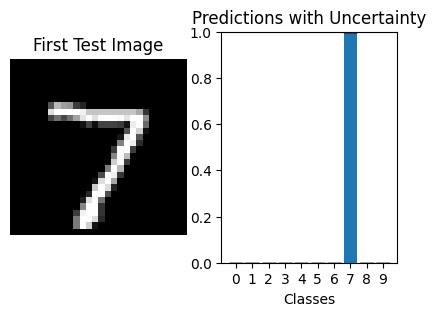

In [ ]:
# function to generate predictions with uncertainty by sampling the model's outputs multiple times.
def predict_with_uncertainty(model, x, num_samples=100):
  predictions = []
  for _ in range(num_samples):
    predictions.append(model(x, training=True))
  predictions = np.array(predictions)
  mean_prediction = np.mean(predictions, axis=0)
  std_prediction = np.std(predictions, axis=0)
  return mean_prediction, std_prediction


# Make multiple predictions for the first test element
first_test_image = x_test[0:1]
mean_prediction, std_prediction = predict_with_uncertainty(model, first_test_image, num_samples=100)

print("mean_prediction",mean_prediction)
print("std_prediction",std_prediction)
# Plot the first test image
plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1)
plt.imshow(x_test[0].squeeze(), cmap='gray')
plt.title("First Test Image")
plt.axis("off")

# Plot predictions with uncertainty
plt.subplot(1, 2, 2)
plt.bar(range(num_classes), mean_prediction[0], yerr=std_prediction[0], capsize=5) #Error bars
plt.xlabel("Classes")
plt.title("Predictions with Uncertainty")
plt.xticks(range(num_classes))
plt.ylim(0,1)
plt.show()

In [ ]:
# Evaluate the model on the test set using the predict_with_uncertainty function
mean_test_predictions, std_test_predictions = predict_with_uncertainty(model, x_test, num_samples=10)

# Calculate the accuracy
predicted_labels = np.argmax(mean_test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(predicted_labels == true_labels)

# Extract the uncertainty of the predicted class
uncertainty_of_predicted_class = std_test_predictions[np.arange(len(predicted_labels)), predicted_labels]

# Calculate the mean uncertainty of the predicted classes
mean_uncertainty_of_predicted_class = np.mean(uncertainty_of_predicted_class)

print(f"Test Accuracy: {accuracy}")
print(f"Mean Uncertainty of Predicted Class: {mean_uncertainty_of_predicted_class}")

Test Accuracy: 0.9912
Mean Uncertainty of Predicted Class: 0.025437628850340843


In [ ]:
# Generate a new test dataset by applying a random rotation to all test elements.
from scipy.ndimage import rotate

def random_rotation_scipy(image, max_angle=90):
    angle = np.random.uniform(-max_angle, max_angle)
    rotated_image = rotate(image, angle, reshape=False, mode='nearest')
    return rotated_image

# Assuming x_test is your test dataset
rotated_x_test = np.array([random_rotation_scipy(img.squeeze()) for img in x_test])
rotated_x_test = np.expand_dims(rotated_x_test, -1) #restore the channel dimension

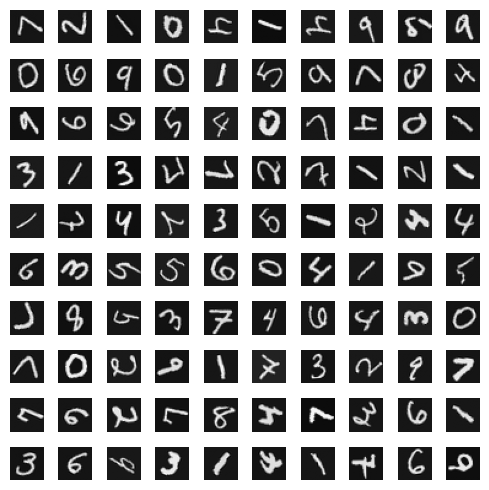

In [ ]:

import matplotlib.pyplot as plt

# Reshape rotated_x_test to (10, 10, 28, 28) for the 10x10 matrix visualization
reshaped_images = rotated_x_test[:100].reshape(10, 10, 28, 28)

fig, axes = plt.subplots(10, 10, figsize=(5, 5))

for i in range(10):
    for j in range(10):
        axes[i, j].imshow(reshaped_images[i, j], cmap='gray')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Now you can use rotated_x_test instead of x_test for further processing
mean_test_predictions, std_test_predictions= predict_with_uncertainty(model, rotated_x_test, num_samples=100)

# Calculate the accuracy
predicted_labels = np.argmax(mean_test_predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(predicted_labels == true_labels)

# Extract the uncertainty of the predicted class
uncertainty_of_predicted_class = std_test_predictions[np.arange(len(predicted_labels)), predicted_labels]

# Calculate the mean uncertainty of the predicted classes
mean_uncertainty_of_predicted_class = np.mean(uncertainty_of_predicted_class)

print(f"Test Accuracy: {accuracy}")
print(f"Mean Uncertainty of Predicted Class: {mean_uncertainty_of_predicted_class}")

Test Accuracy: 0.5613
Mean Uncertainty of Predicted Class: 0.1961420476436615


In [ ]:
print(predicted_labels[4])
print(true_labels[4])
print(mean_test_predictions[4])
print(std_test_predictions[4])

5
4
[8.2617551e-03 2.4752130e-03 1.8503344e-02 9.0739904e-03 2.9451870e-05
 9.4058883e-01 1.1988209e-02 1.4126693e-05 8.4871966e-03 5.7787594e-04]
[2.85000764e-02 1.35547360e-02 1.16198964e-01 2.46127788e-02
 1.57367482e-04 1.62624806e-01 6.82229847e-02 5.69899021e-05
 6.83137402e-02 2.93051824e-03]


## Exercise 1

+ **Develop and train** a linear model (not a neural network) to classify images as either "correctly classified" or "incorrectly classified" using prediction uncertainty as the key feature. High-confidence predictions should be generally associated with images that align more closely with the training distribution (e.g., non-rotated images). **Evaluate and report** the accuracy of this classifier.

+  To analyze the results, **visualize** the prediction confidence distribution (measured as the standard deviation of the softmax probabilities for the predicted class) using two overlapping histograms:
    + One histogram for correctly classified images.
    + One histogram for incorrectly classified images.

    X-axis label: "Standard Deviation of Softmax Probabilities (Prediction Confidence)"

    Y-axis label: "Number of Images" or "Frequency"

    Insight: Clear clustering of correctly classified vs. incorrectly classified images indicates that the classifier successfully learns to differentiate the two based on prediction confidence.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Identify correct and incorrect classifications
correctly_classified = predicted_labels == true_labels
incorrectly_classified = ~correctly_classified

#use the standard deviation of softmax probabilities as the feature
uncertainty_features = np.concatenate([std_test_predictions[np.arange(len(correctly_classified)), predicted_labels]], axis=0)
uncertainty_features = uncertainty_features.reshape(-1, 1)

# Prepare labels for linear classifier: 1 for correct, 0 for incorrect
labels_for_classifier = correctly_classified.astype(int)

#train the linear classifier
classifier = LogisticRegression()
classifier.fit(uncertainty_features, labels_for_classifier)

uncertainty_of_predicted_class = uncertainty_of_predicted_class.reshape(-1, 1)

#predict on the test set
classifier_predictions = classifier.predict(uncertainty_of_predicted_class)

#calculate accuracy
accuracy = accuracy_score(labels_for_classifier, classifier_predictions)
print(f"Linear Classifier Accuracy: {accuracy:.2f}")

Linear Classifier Accuracy: 0.78


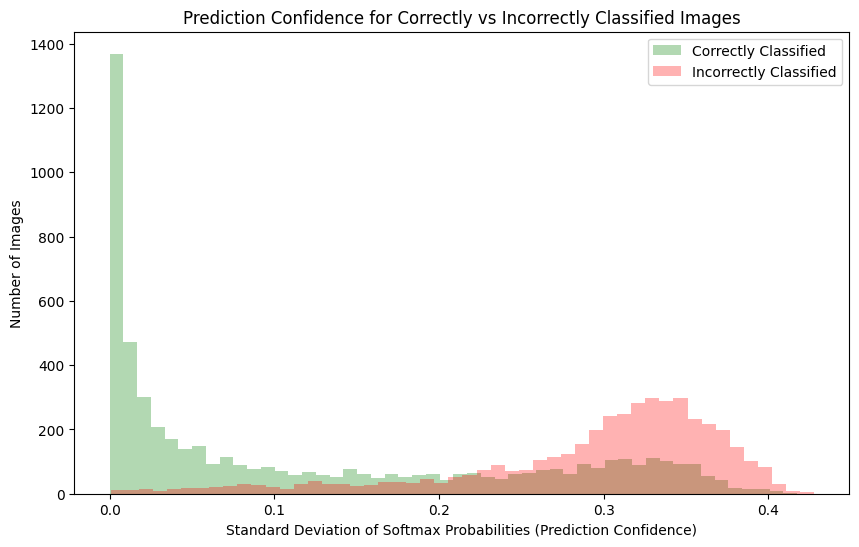

In [ ]:
#Extract the standard deviation for correctly and incorrectly classified images
std_correct = std_test_predictions[np.arange(len(correctly_classified)), predicted_labels][correctly_classified]
std_incorrect = std_test_predictions[np.arange(len(incorrectly_classified)), predicted_labels][incorrectly_classified]

#plot histograms for both groups
plt.figure(figsize=(10, 6))

#histogram for correctly classified images
plt.hist(std_correct, bins=50, alpha=0.3, label="Correctly Classified", color='g')

#histogram for incorrectly classified images
plt.hist(std_incorrect, bins=50, alpha=0.3, label="Incorrectly Classified", color='r')

plt.xlabel("Standard Deviation of Softmax Probabilities (Prediction Confidence)")
plt.ylabel("Number of Images")
plt.title("Prediction Confidence for Correctly vs Incorrectly Classified Images")
plt.legend()

plt.show()



## Exercise 2

If you want to use a measure other than the standard deviation (std) to quantify uncertainty, there are several alternative approaches. Each captures uncertainty from a different perspective, which might be more suitable depending on your application. Below are some options:

+ **Entropy** measures the "spread" of the predicted probability distribution. High entropy indicates a flat distribution (greater uncertainty), while low entropy indicates a sharp distribution (high confidence).
+ The **variation ratio** measures the proportion of stochastic forward passes where the model's most confident class does not match the mode class.
+ The **difference between the maximum and minimum predicted probabilities** across Monte Carlo passes for the predicted class.
+ **Least confidence**: the difference between the probability of the predicted class and 100% probability.
+ **Margin of confidence**: the difference between the probability of the top two most confident predictions.

Can you think of a better strategy to use uncertainty to classify images as either "correctly classified" or "incorrectly classified" based on this measures? Report the accuracy of the best classifier you can develop.


#### 1) Entropy

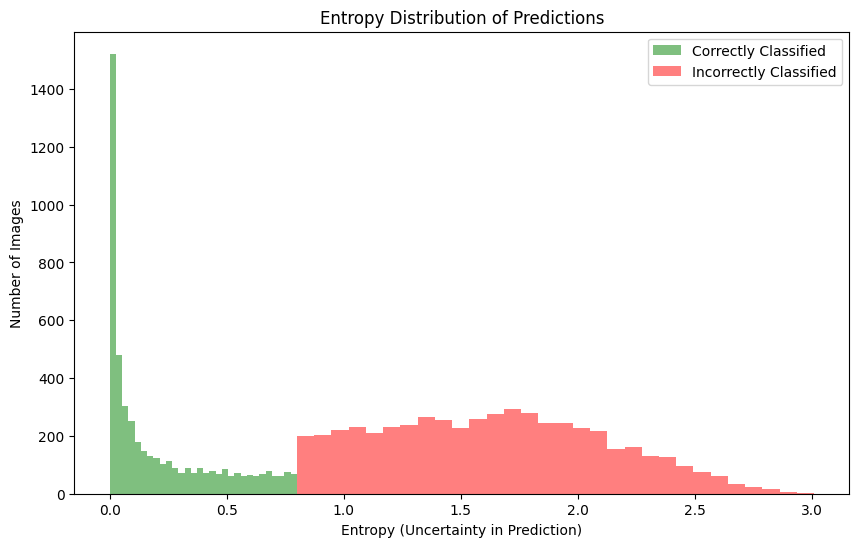

Accuracy of the uncertainty-based classifier: 0.7758


In [ ]:
from scipy.stats import entropy

#compute entropy for a given prediction
def compute_entropy(probabilities):
    return entropy(probabilities, base=2)

#classify image based on uncertainty
def classify_based_on_uncertainty(model, x, y, num_samples=100, entropy_threshold=0.8):
    #generate uncertainty metrics over multiple forward passes
    predictions = [model(x, training=True).numpy() for _ in range(num_samples)]
    predictions = np.array(predictions)

    mean_predictions = np.mean(predictions, axis=0)

    entropies = np.array([compute_entropy(pred) for pred in mean_predictions])

    correct_classifications = []
    for i in range(len(x)):
        if entropies[i] > entropy_threshold:
            correct_classifications.append(False)
        else:
            correct_classifications.append(True)

    #compute accuracy based on true labels and predicted classifications
    true_labels = np.argmax(y, axis=1)
    accuracy = np.mean([correct_classifications[i] == (pred == true_labels[i]) for i, pred in enumerate(np.argmax(mean_predictions, axis=1))])

    #visualize confidence distribution
    correct_entropies = entropies[np.array(correct_classifications)]  # Entropies of correctly classified images
    incorrect_entropies = entropies[~np.array(correct_classifications)]  # Entropies of incorrectly classified images

    #plot histograms for correctly and incorrectly classified images
    plt.figure(figsize=(10, 6))
    plt.hist(correct_entropies, bins=30, alpha=0.5, label="Correctly Classified", color="g", density=False)
    plt.hist(incorrect_entropies, bins=30, alpha=0.5, label="Incorrectly Classified", color="r", density=False)

    plt.title("Entropy Distribution of Predictions")
    plt.xlabel("Entropy (Uncertainty in Prediction)")
    plt.ylabel("Number of Images")
    plt.legend(loc="upper right")
    plt.show()

    return accuracy

accuracy = classify_based_on_uncertainty(model, rotated_x_test, y_test, num_samples=100)
print(f"Accuracy of the uncertainty-based classifier: {accuracy}")


#### 2) Least Confidence

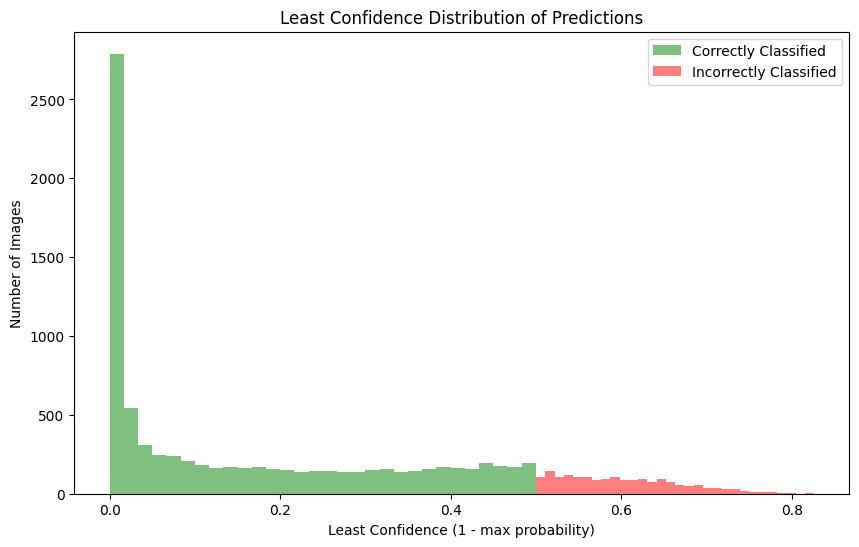

Accuracy of the uncertainty-based classifier: 0.6669


In [ ]:
#function to calculate least confidence
def compute_least_confidence(probabilities):
    return 1 - np.max(probabilities)

#classify image based on uncertainty
def classify_based_on_uncertainty(model, x, y, num_samples=100, least_confidence_threshold=0.5):
    #generate uncertainty metrics over multiple forward passes
    predictions = [model(x, training=True).numpy() for _ in range(num_samples)]
    predictions = np.array(predictions)

    mean_predictions = np.mean(predictions, axis=0)

    #calculate uncertainty measures
    entropies = np.array([compute_entropy(pred) for pred in mean_predictions])
    least_confidences = np.array([compute_least_confidence(pred) for pred in mean_predictions])
    margins_of_confidence = np.array([compute_margin_of_confidence(pred) for pred in mean_predictions])

    correct_classifications = []
    for i in range(len(x)):
        if least_confidences[i] > least_confidence_threshold:
            correct_classifications.append(False)
        else:
            correct_classifications.append(True)

    true_labels = np.argmax(y, axis=1)
    accuracy = np.mean([correct_classifications[i] == (pred == true_labels[i]) for i, pred in enumerate(np.argmax(mean_predictions, axis=1))])

    #visualize confidence distribution
    correct_least_confidences = least_confidences[np.array(correct_classifications)]  # Least confidence for correctly classified images
    incorrect_least_confidences = least_confidences[~np.array(correct_classifications)]  # Least confidence for incorrectly classified images

    #plot histograms for correctly and incorrectly classified images
    plt.figure(figsize=(10, 6))
    plt.hist(correct_least_confidences, bins=30, alpha=0.5, label="Correctly Classified", color="g", density=False)
    plt.hist(incorrect_least_confidences, bins=30, alpha=0.5, label="Incorrectly Classified", color="r", density=False)

    plt.title("Least Confidence Distribution of Predictions")
    plt.xlabel("Least Confidence (1 - max probability)")
    plt.ylabel("Number of Images")
    plt.legend(loc="upper right")
    plt.show()

    return accuracy


accuracy = classify_based_on_uncertainty(model, rotated_x_test, y_test, num_samples=100)
print(f"Accuracy of the uncertainty-based classifier: {accuracy}")

#### 3) Variation Ratio

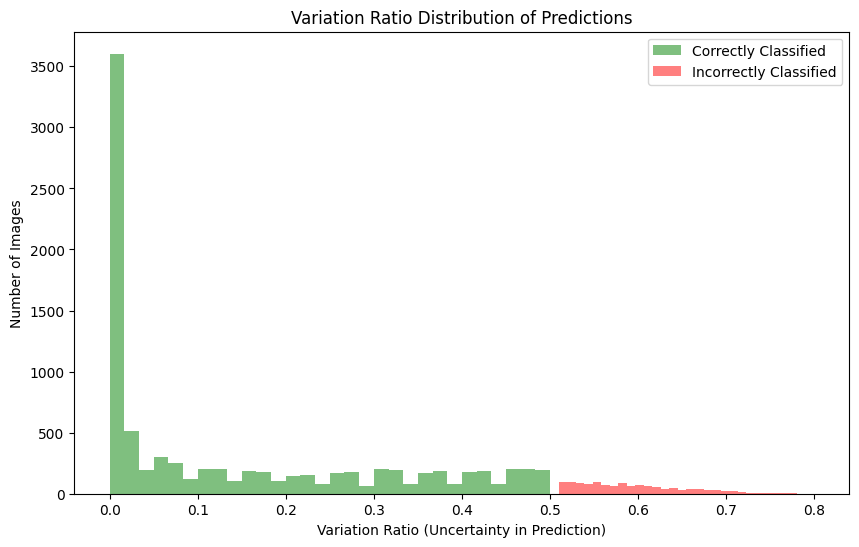

Accuracy of the uncertainty-based classifier: 0.639


In [ ]:
# Function to calculate margin of confidence
def variation_ratio(predictions):
  # For each image, find the most frequent class predicted across all stochastic forward passes
  predicted_classes = np.argmax(predictions, axis=-1)  # Find the predicted class for each pass
  most_frequent_class = np.bincount(predicted_classes).argmax()
  variation = np.mean(predicted_classes != most_frequent_class)  # Check where the predicted class changes
  return variation

#classify image based on uncertainty
def classify_based_on_uncertainty(model, x, y, num_samples=100, variation_threshold=0.5):
    #generate uncertainty metrics over multiple forward passes
    predictions = [model(x, training=True).numpy() for _ in range(num_samples)]
    predictions = np.array(predictions)

    mean_predictions = np.mean(predictions, axis=0)

    #calculate variation ratio for each image
    variation_ratios = []
    for i in range(len(x)):
        variation_ratios.append(variation_ratio(predictions[:, i]))  # Calculate for each image individually

    #convert variation_ratios to numpy array
    variation_ratios = np.array(variation_ratios)

    #make classification decision based on thresholds
    correct_classifications = []
    for i in range(len(x)):
        if variation_ratios[i] > variation_threshold:
            correct_classifications.append(False)
        else:
            correct_classifications.append(True)

    #compute accuracy based on true labels and predicted classifications
    true_labels = np.argmax(y, axis=1)
    accuracy = np.mean([correct_classifications[i] == (pred == true_labels[i]) for i, pred in enumerate(np.argmax(mean_predictions, axis=1))])

    #visualize variation ratio distribution
    correct_variation_ratios = variation_ratios[np.array(correct_classifications)]  # Variation ratios for correctly classified images
    incorrect_variation_ratios = variation_ratios[~np.array(correct_classifications)]  # Variation ratios for incorrectly classified images

    #plot histograms for correctly and incorrectly classified images
    plt.figure(figsize=(10, 6))
    plt.hist(correct_variation_ratios, bins=30, alpha=0.5, label="Correctly Classified", color="g", density=False)
    plt.hist(incorrect_variation_ratios, bins=30, alpha=0.5, label="Incorrectly Classified", color="r", density=False)

    plt.title("Variation Ratio Distribution of Predictions")
    plt.xlabel("Variation Ratio (Uncertainty in Prediction)")
    plt.ylabel("Number of Images")
    plt.legend(loc="upper right")
    plt.show()

    return accuracy


accuracy = classify_based_on_uncertainty(model, rotated_x_test, y_test, num_samples=100)
print(f"Accuracy of the uncertainty-based classifier: {accuracy}")

#### 4) The difference between maximum and minimum probabilities

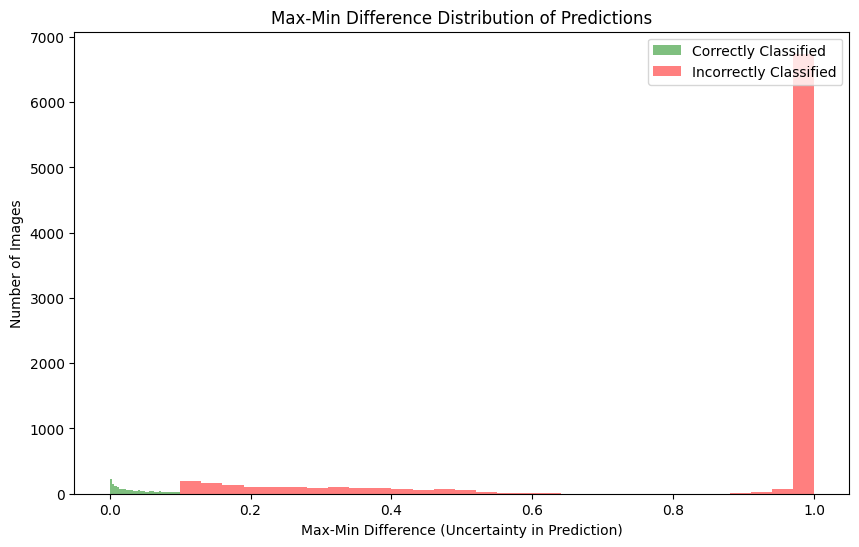

Accuracy of the max-min difference-based classifier: 0.6034


In [ ]:
def max_min_difference(predictions):
    predicted_classes = np.argmax(predictions, axis=-1)  # Shape: (num_samples, num_images)

    max_min_diff = []
    for i in range(predictions.shape[1]):
        predicted_class_probs = predictions[:, i, predicted_classes[:, i]]  # Shape: (num_samples,)

        max_prob = np.max(predicted_class_probs)
        min_prob = np.min(predicted_class_probs)

        #compute the difference between the max and min probabilities
        max_min_diff.append(max_prob - min_prob)

    return np.array(max_min_diff)

def classify_based_on_max_min_difference(model, x, y, num_samples=100, diff_threshold=0.1):
    #generate uncertainty metrics over multiple forward passes
    predictions = [model(x, training=True).numpy() for _ in range(num_samples)]
    predictions = np.array(predictions)  # Shape: (num_samples, num_images, num_classes)

    #calculate max-min difference for each image
    max_min_diffs = max_min_difference(predictions)

    correct_classifications = []
    for i in range(len(x)):
        if max_min_diffs[i] > diff_threshold:
            correct_classifications.append(False)
        else:
            correct_classifications.append(True)

    true_labels = np.argmax(y, axis=1)
    predicted_labels = np.argmax(np.mean(predictions, axis=0), axis=1)  # Mean prediction over samples

    accuracy = np.mean([correct_classifications[i] == (pred == true_labels[i]) for i, pred in enumerate(predicted_labels)])

    #visualize the distribution of max-min difference for correct vs incorrect classifications
    correct_max_min_diffs = max_min_diffs[np.array(correct_classifications)]  # For correctly classified images
    incorrect_max_min_diffs = max_min_diffs[~np.array(correct_classifications)]  # For incorrectly classified images

    #plot histograms for correct vs incorrect classifications
    plt.figure(figsize=(10, 6))
    plt.hist(correct_max_min_diffs, bins=30, alpha=0.5, label="Correctly Classified", color="g", density=False)
    plt.hist(incorrect_max_min_diffs, bins=30, alpha=0.5, label="Incorrectly Classified", color="r", density=False)

    plt.title("Max-Min Difference Distribution of Predictions")
    plt.xlabel("Max-Min Difference (Uncertainty in Prediction)")
    plt.ylabel("Number of Images")
    plt.legend(loc="upper right")
    plt.show()

    return accuracy


accuracy = classify_based_on_max_min_difference(model, rotated_x_test, y_test, num_samples=100)
print(f"Accuracy of the max-min difference-based classifier: {accuracy}")

#### 5) Margin of Confidence

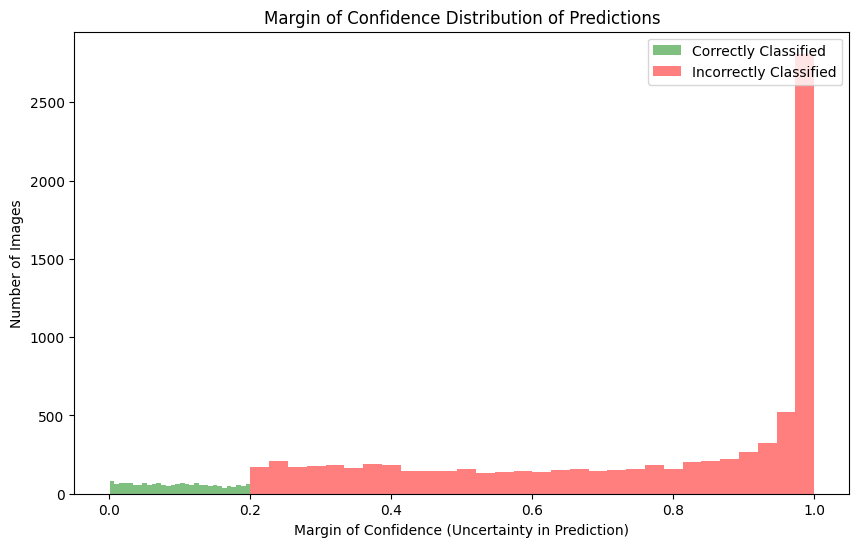

Accuracy of the uncertainty-based classifier: 0.3466


In [ ]:
#function to calculate margin of confidence
def compute_margin_of_confidence(probabilities):
    sorted_probs = np.sort(probabilities)[::-1]  # Sort descending
    return sorted_probs[0] - sorted_probs[1]  # Difference between top two probabilities

#classify image based on uncertainty
def classify_based_on_uncertainty(model, x, y, num_samples=100, margin_threshold=0.2):
    #generate uncertainty metrics over multiple forward passes
    predictions = [model(x, training=True).numpy() for _ in range(num_samples)]
    predictions = np.array(predictions)

    mean_predictions = np.mean(predictions, axis=0)

    #calculate uncertainty measures
    margins_of_confidence = np.array([compute_margin_of_confidence(pred) for pred in mean_predictions])

    #make classification decision based on thresholds
    correct_classifications = []
    for i in range(len(x)):
        # If entropy is high or least confidence is high, classify as incorrect
        if margins_of_confidence[i] > margin_threshold:
            correct_classifications.append(False)
        else:
            correct_classifications.append(True)

    #compute accuracy based on true labels and predicted classifications
    true_labels = np.argmax(y, axis=1)
    accuracy = np.mean([correct_classifications[i] == (pred == true_labels[i]) for i, pred in enumerate(np.argmax(mean_predictions, axis=1))])

    #visualize the distribution of margins for correct vs incorrect classifications
    correct_margins = margins_of_confidence[np.array(correct_classifications)]  # For correctly classified images
    incorrect_margins = margins_of_confidence[~np.array(correct_classifications)]  # For incorrectly classified images

    #plot histograms for correct vs incorrect classifications
    plt.figure(figsize=(10, 6))

    plt.hist(correct_margins, bins=30, alpha=0.5, label="Correctly Classified", color="g",  density=False)

    plt.hist(incorrect_margins, bins=30, alpha=0.5, label="Incorrectly Classified", color="r",  density=False)

    plt.title("Margin of Confidence Distribution of Predictions")
    plt.xlabel("Margin of Confidence (Uncertainty in Prediction)")
    plt.ylabel("Number of Images")
    plt.legend(loc="upper right")
    plt.show()

    return accuracy


accuracy = classify_based_on_uncertainty(model, rotated_x_test, y_test, num_samples=100)
print(f"Accuracy of the uncertainty-based classifier: {accuracy}")